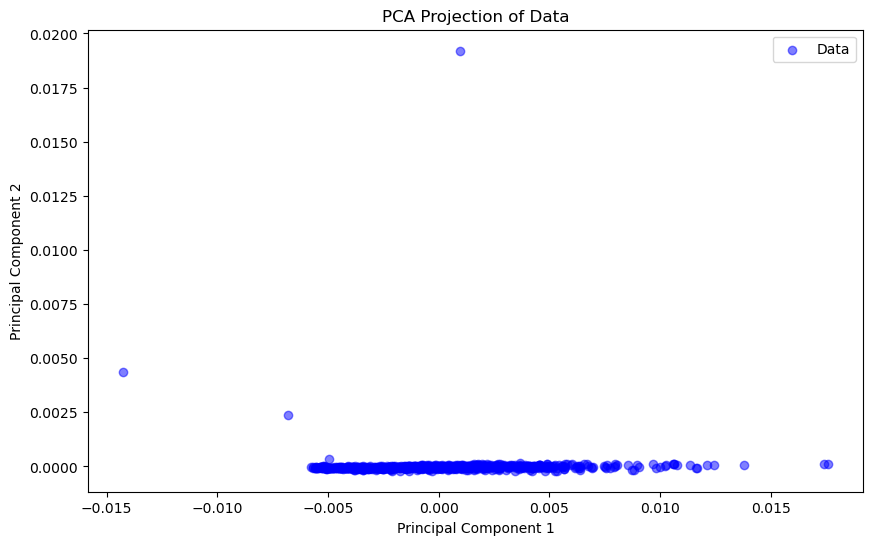

C:\Users\steph\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\steph\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score for False Positives Clustering: 0.5358

After Post-Processing:
Confusion Matrix:
[[ 76  42]
 [  3 127]]
TNR (True Negative Rate): 0.6441
TPR (True Positive Rate): 0.9769
FPR (False Positive Rate): 0.3559
FNR (False Negative Rate): 0.0231
Accuracy: 0.8185
F1 Score: 0.8495


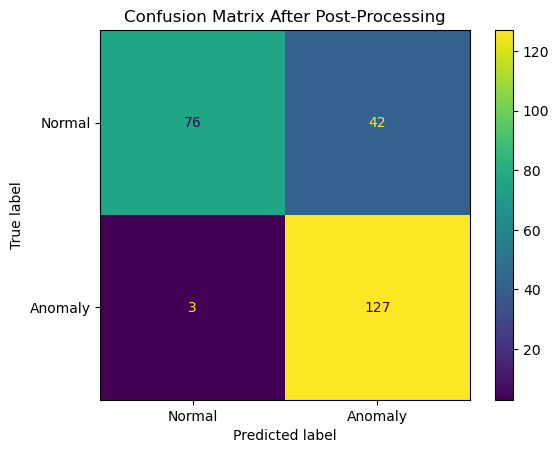

In [83]:
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data without labels (unsupervised)
folder_path = 'ROFreq'
data_rows = []

for file_name in sorted(os.listdir(folder_path)):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(folder_path, file_name)
        data = pd.read_excel(file_path, header=None)
        data_rows.append(data.values)  # Raw data

# Combine all features into a single dataset
data = np.vstack(data_rows)

# Step 1: Compute Row Weights
row_weights = np.var(data, axis=1)
row_weights = row_weights / np.sum(row_weights)  # Normalize weights

# Step 2: Scale Data with Row Weights
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_weighted = data_scaled * row_weights[:, np.newaxis]  # Apply weights to rows

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_weighted)

# Visualize PCA results
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5, color='blue', label='Data')
plt.title('PCA Projection of Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Separate dataset into training and testing for classification
X_train, X_test, y_train, y_test = train_test_split(data_weighted, np.random.randint(0, 2, data_weighted.shape[0]), test_size=0.3, random_state=42)

# Expanded SVM Parameter Grid
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],  # Kernel types
    'degree': [2, 3, 4],  # Degree for polynomial kernel (only used if kernel='poly')
}

# Expanded KNN Parameter Grid
knn_param_grid = {
    'n_neighbors': [1, 3, 5, 7, 10, 15, 20],  # Number of neighbors
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'cosine'],  # Distance metrics
    'weights': ['uniform', 'distance'],  # Weighting of neighbors
}

# SVM Grid Search
best_svm_score = -np.inf
best_svm_params = None
for params in ParameterGrid(svm_param_grid):
    svm_clf = SVC(**params)
    svm_clf.fit(X_train, y_train)
    score = svm_clf.score(X_test, y_test)  # Evaluate on test set
    if score > best_svm_score:
        best_svm_score = score
        best_svm_params = params

# Train SVM with best parameters
svm_clf = SVC(**best_svm_params)
svm_clf.fit(X_train, y_train)

# Predict with SVM
svm_preds = svm_clf.predict(X_test)

# KNN Grid Search
best_knn_score = -np.inf
best_knn_params = None
for params in ParameterGrid(knn_param_grid):
    knn_clf = KNeighborsClassifier(**params)  # Use KNeighborsClassifier
    knn_clf.fit(X_train, y_train)
    knn_preds = knn_clf.predict(X_test)
    score = accuracy_score(y_test, knn_preds)
    if score > best_knn_score:
        best_knn_score = score
        best_knn_params = params

# Train KNN with the best parameters
knn_clf = KNeighborsClassifier(**best_knn_params)
knn_clf.fit(X_train, y_train)

# Predict with KNN
knn_preds = knn_clf.predict(X_test)

# Combine SVM and KNN predictions
combined_preds = (svm_preds + knn_preds) >= 1

# Post-Processing to Refine False Positives
false_positive_idx = np.where((y_test == 0) & (combined_preds == 1))[0]
false_positive_data = X_test[false_positive_idx]

# Apply KMeans clustering to false positives
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(false_positive_data)
fp_clusters = kmeans.predict(false_positive_data)

# Silhouette Score to validate clustering
silhouette_avg = silhouette_score(false_positive_data, fp_clusters)
print(f"Silhouette Score for False Positives Clustering: {silhouette_avg:.4f}")

# Update Combined Predictions
for i, idx in enumerate(false_positive_idx):
    if fp_clusters[i] == 0:  # Reclassify as normal if clustered as normal
        combined_preds[idx] = 0

# Recalculate Metrics After Post-Processing
conf_matrix = confusion_matrix(y_test, combined_preds)
tn, fp, fn, tp = conf_matrix.ravel()

TNR = tn / (tn + fp) if (tn + fp) > 0 else 0
TPR = tp / (tp + fn) if (tp + fn) > 0 else 0
FPR = fp / (fp + tn) if (fp + tn) > 0 else 0
FNR = fn / (fn + tp) if (fn + tp) > 0 else 0
accuracy = accuracy_score(y_test, combined_preds)
f1 = f1_score(y_test, combined_preds)

# Print updated metrics
print("\nAfter Post-Processing:")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"TNR (True Negative Rate): {TNR:.4f}")
print(f"TPR (True Positive Rate): {TPR:.4f}")
print(f"FPR (False Positive Rate): {FPR:.4f}")
print(f"FNR (False Negative Rate): {FNR:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display updated confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='viridis')
plt.title('Confusion Matrix After Post-Processing')
plt.show()


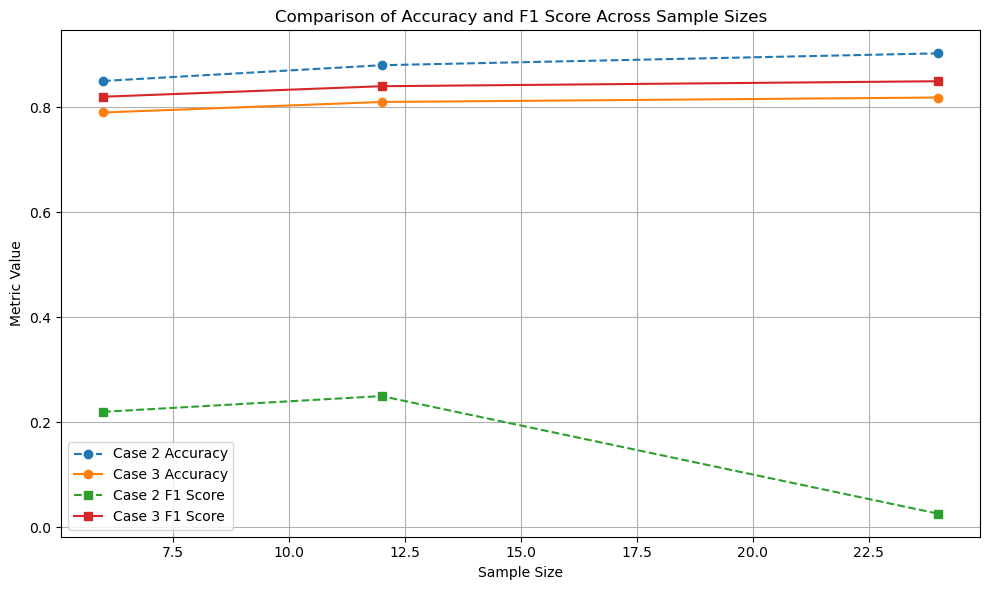

In [88]:
import matplotlib.pyplot as plt

# Example data for metrics across sample sizes
case2_results = {
    'Sample Size': [6, 12, 24],
    'Accuracy': [0.85, 0.88, 0.9026],
    'F1 Score': [0.22, 0.25, 0.0260]
}
case3_results = {
    'Sample Size': [6, 12, 24],
    'Accuracy': [0.79, 0.81, 0.8185],
    'F1 Score': [0.82, 0.84, 0.8495]
}

# Convert to DataFrames
case2_df = pd.DataFrame(case2_results)
case3_df = pd.DataFrame(case3_results)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(case2_df['Sample Size'], case2_df['Accuracy'], label='Case 2 Accuracy', marker='o', linestyle='--')
plt.plot(case3_df['Sample Size'], case3_df['Accuracy'], label='Case 3 Accuracy', marker='o', linestyle='-')
plt.plot(case2_df['Sample Size'], case2_df['F1 Score'], label='Case 2 F1 Score', marker='s', linestyle='--')
plt.plot(case3_df['Sample Size'], case3_df['F1 Score'], label='Case 3 F1 Score', marker='s', linestyle='-')

# Add labels and legend
plt.title('Comparison of Accuracy and F1 Score Across Sample Sizes')
plt.xlabel('Sample Size')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot as an image
plt.savefig('comparison_plot.png')
plt.show()
